In [1]:
import torch as t
from scipy import ndimage
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
#device = t.device('cuda' if t.cuda.is_available() else 'cpu')
device = t.device('cpu')

In [3]:
MOORE_OFFSETS = t.tensor([(1, 1), (1, -1), (1, 0), (-1, 0), (0, 0), (-1, 1), (-1, -1), (0, 1), (0, -1)], device=device)
def get_moore_nbh(batch:t.Tensor):
    batch_size, batch_height, batch_width = batch.shape
    cell_pixel_coords = (batch == 1).nonzero()
    nbh_coords = (cell_pixel_coords[:, 1:].unsqueeze(1)+MOORE_OFFSETS.type(t.float).unsqueeze(0))
    idx_pad = cell_pixel_coords[:, 0].repeat(9,1).T.reshape(cell_pixel_coords[:, 0].shape[0], 9, 1)
    nbh_coords[nbh_coords == -1] = 1
    nbh_coords[nbh_coords == batch_height] = batch_height -2
    return t.concatenate((idx_pad, nbh_coords), dim=-1)

In [37]:
STEP_SIZES = t.tensor([(1, 1), (1, -1), (1, 0), (-1, 0), (-1, 1), (-1, -1), (0, 1), (0, -1)], device=device)

def MCS(batch, target_vol, temperature):
    batch_size, batch_height, batch_width = batch.shape
    frontiers = get_moore_nbh(batch)
    
    src_coords = []
    for batch_idx in range(batch_size):
        frontier = frontiers[frontiers[:, :, 0] == batch_idx, :].unique(dim=0)
        src_coords.append(random.choice(frontier).type(t.long))
    batch_src_coords = t.vstack(src_coords)
    step_sizes = t.vstack(random.choices(STEP_SIZES, k=batch_src_coords.shape[0]))
    tgt_coords = t.hstack((batch_src_coords[:, 0].unsqueeze(0).T, batch_src_coords[:, 1:] + step_sizes))
    tgt_coords[:, 1:][tgt_coords[:, 1:] == -1] = 1
    tgt_coords[:, 1:][tgt_coords[:, 1:] == batch_height] = batch_height -2
    tgt_i = tgt_coords[:, 0]
    tgt_j = tgt_coords[:, 1]
    tgt_k = tgt_coords[:, 2]
    src_i = batch_src_coords[:, 0]
    src_j = batch_src_coords[:, 1]
    src_k = batch_src_coords[:, 2]
    
    #print(src_i, src_j, src_k)
    #print(tgt_i, tgt_j, tgt_k)
    
    current_volumes = t.sum(batch, dim=(-1, -2))
    vol_changes = (-1 * batch[tgt_i, tgt_j, tgt_k]) + batch[src_i, src_j, src_k]
    adjusted_vols = current_volumes + vol_changes
    
    #print(current_volumes)
    #print(vol_changes)
    #print(adjusted_vols)
    
    unequal_mask = batch[tgt_i, tgt_j, tgt_k] != batch[src_i, src_j, src_k]
    sml_eq_two_mask = adjusted_vols <= 2
    greater_zero_mask = adjusted_vols > 0
    vol_change_positive_mask = vol_changes > 0
    vol_change_negative_mask = vol_changes < 0
    
    auto_upd_mask = t.logical_and(
        vol_change_negative_mask,
        greater_zero_mask
    )
    
    #print(auto_upd_mask)
    
    auto_upd_i = tgt_i[auto_upd_mask]
    auto_upd_j = tgt_j[auto_upd_mask]
    auto_upd_k = tgt_k[auto_upd_mask]
    
    batch[auto_upd_i, auto_upd_j, auto_upd_k] += vol_changes[auto_upd_mask]
    
     
    update_mask = t.logical_and(
        vol_change_positive_mask,
        t.logical_and(
            greater_zero_mask,
            t.logical_and(unequal_mask, sml_eq_two_mask)
        )
    )
    
    #print(update_mask)
    
    #print(vol_changes[update_mask])
    #print(adjusted_vols[update_mask])
    #print(f"delta h {-((target_vol - adjusted_vols[update_mask]) ** 2)}")
    update_probabilities = t.exp(-((target_vol - adjusted_vols[update_mask]) ** 2) / temperature)
    #print(f"prob: {update_probabilities}")
    logits = t.cat((update_probabilities.unsqueeze(0), (1-update_probabilities).unsqueeze(0))).T
    #print(f"logits: {logits}")
    one_hot = t.nn.functional.gumbel_softmax(t.log(logits), hard=True)
    #print(one_hot)
    upd_vals = one_hot[:,0] * vol_changes[update_mask]
    
    upd_i = tgt_i[update_mask]
    upd_j = tgt_j[update_mask]
    upd_k = tgt_k[update_mask]
    
    #print(upd_i, upd_j, upd_k)
    
    batch[upd_i, upd_j, upd_k] += upd_vals.squeeze()
    
    return batch
    

In [38]:
def step(batch:t.Tensor, dist_matrix:t.Tensor, temperature:t.Tensor, target_vol:float, eta:float, num_steps:int):
    for i in tqdm(range(num_steps)):
        batch = MCS(batch, target_vol, temperature)
        if t.any(t.sum(batch, dim=(-1,-2)) == 0) or t.any(t.sum(batch, dim=(-1,-2)) > 2):
            print("ISSUE DETECTED, STOP SIM")
            return None, None
    # calc the distance after 100 steps    
    distances = t.sum(batch * dist_matrix, dim=(-1,-2)) / t.sum(batch, dim=(-1,-2))
    mean_distance = t.mean(distances)
    print(f"temperature: {temperature}, mean distance: {mean_distance}")
    grad = t.autograd.grad(mean_distance, temperature)[0]
    print(f"gradient: {grad}")
    return t.clamp(temperature - (eta * grad), min=1e-5, max=40.), grad, mean_distance

In [39]:
def create_dist_matrix(batch:t.Tensor):
    dist_matrix:np.ndarray = ndimage.distance_transform_edt(1-batch[0].cpu(), return_indices=False)
    dist_matrix = dist_matrix**2
    dist_matrix_t = t.from_numpy(dist_matrix).to(device)
    return dist_matrix_t

# Visualize sample sim

In [41]:
temperature = 27.
target_vol = 1.
batch = t.zeros(1,8,8, device=device)
batch[:,4,4] += 1

states = []
for i in tqdm(range(10000)):
    batch = MCS(batch, target_vol, temperature)
    if t.any(t.sum(batch, dim=(-1,-2)) == 0) or t.any(t.sum(batch, dim=(-1,-2)) > 2):
        print("ISSUE DETECTED, STOP SIM")
        break
    else:
        states.append(batch[0].detach().clone().cpu().numpy())

imgs = [Image.fromarray((1-state)*255) for state in states]
print(len(imgs))
imgs[0].save("test.gif", save_all=True, append_images=imgs[1:], fps=60)

100%|██████████| 10000/10000 [00:10<00:00, 969.87it/s]


10000


# Num_steps = 40, 8x8 grid

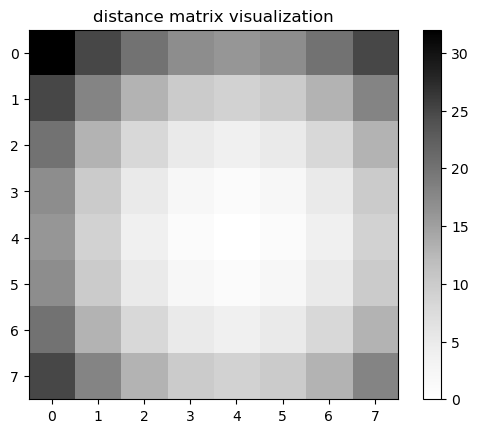

In [42]:
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
fig = plt.imshow(dist_matrix.numpy(), cmap="Greys", interpolation="nearest", vmin=0, vmax=np.max(dist_matrix.numpy()))
plt.colorbar(fig)
plt.title("distance matrix visualization")
plt.show()

target_vol = 0, 8x8 grid

In [43]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 0.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)

grads_v0 = []
mean_distances_v0 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40)
    grads_v0.append(grad.detach().cpu().numpy())
    mean_distances_v0.append(mean_distance.detach().cpu().numpy())

100%|██████████| 40/40 [00:00<00:00, 54.05it/s]


temperature: 0.0, mean distance: 0.0
gradient: nan


100%|██████████| 40/40 [00:00<00:00, 58.98it/s]


temperature: 0.05263157933950424, mean distance: 0.0
gradient: 9.247589758099716e-29


100%|██████████| 40/40 [00:00<00:00, 58.38it/s]


temperature: 0.10526315867900848, mean distance: 0.0
gradient: 5.9537444419e-13


100%|██████████| 40/40 [00:00<00:00, 53.55it/s]


temperature: 0.15789473056793213, mean distance: 0.0
gradient: 4.7003862135852614e-08


100%|██████████| 40/40 [00:00<00:00, 52.98it/s]


temperature: 0.21052631735801697, mean distance: 0.0
gradient: 3.5805904190056026e-05


100%|██████████| 40/40 [00:00<00:00, 47.80it/s]


temperature: 0.2631579041481018, mean distance: 0.0
gradient: 0.0005748480325564742


100%|██████████| 40/40 [00:00<00:00, 46.42it/s]


temperature: 0.31578946113586426, mean distance: 0.0
gradient: 0.006292067468166351


100%|██████████| 40/40 [00:00<00:00, 56.33it/s]


temperature: 0.3684210479259491, mean distance: 0.0
gradient: 0.019752101972699165


100%|██████████| 40/40 [00:00<00:00, 56.25it/s]


temperature: 0.42105263471603394, mean distance: 0.0
gradient: 0.06602843850851059


100%|██████████| 40/40 [00:00<00:00, 51.75it/s]


temperature: 0.4736842215061188, mean distance: 0.0
gradient: 0.1318429559469223


100%|██████████| 40/40 [00:00<00:00, 58.81it/s]


temperature: 0.5263158082962036, mean distance: 0.0
gradient: 0.3112806975841522


100%|██████████| 40/40 [00:00<00:00, 55.86it/s]


temperature: 0.5789473652839661, mean distance: 0.0
gradient: 0.38186851143836975


100%|██████████| 40/40 [00:00<00:00, 56.89it/s]


temperature: 0.6315789222717285, mean distance: 0.010000000000000002
gradient: 0.3573499321937561


100%|██████████| 40/40 [00:00<00:00, 53.83it/s]


temperature: 0.6842105388641357, mean distance: 0.01
gradient: 0.4949610233306885


100%|██████████| 40/40 [00:00<00:00, 58.64it/s]


temperature: 0.7368420958518982, mean distance: 0.01
gradient: 0.6001582741737366


100%|██████████| 40/40 [00:00<00:00, 49.27it/s]


temperature: 0.7894736528396606, mean distance: 0.010000000000000002
gradient: 0.6856259703636169


100%|██████████| 40/40 [00:00<00:00, 59.42it/s]


temperature: 0.8421052694320679, mean distance: 0.035
gradient: 0.7226801514625549


100%|██████████| 40/40 [00:00<00:00, 58.47it/s]


temperature: 0.8947368264198303, mean distance: 0.06
gradient: 0.8335529565811157


100%|██████████| 40/40 [00:00<00:00, 55.17it/s]


temperature: 0.9473684430122375, mean distance: 0.0
gradient: 0.7167523503303528


100%|██████████| 40/40 [00:00<00:00, 57.87it/s]


temperature: 1.0, mean distance: 0.06000000000000002
gradient: 0.7077077031135559


100%|██████████| 40/40 [00:00<00:00, 58.04it/s]


temperature: 1.0, mean distance: 0.035
gradient: 0.7371425628662109


100%|██████████| 40/40 [00:00<00:00, 58.04it/s]


temperature: 2.0, mean distance: 0.41
gradient: 0.2965855896472931


100%|██████████| 40/40 [00:00<00:00, 57.87it/s]


temperature: 3.0, mean distance: 0.9450000000000002
gradient: 0.1434016227722168


100%|██████████| 40/40 [00:00<00:00, 53.05it/s]


temperature: 4.0, mean distance: 1.07
gradient: 0.07584819197654724


100%|██████████| 40/40 [00:00<00:00, 54.94it/s]


temperature: 5.0, mean distance: 1.41
gradient: 0.04036786034703255


100%|██████████| 40/40 [00:00<00:00, 54.42it/s]


temperature: 6.0, mean distance: 1.335
gradient: 0.021330446004867554


100%|██████████| 40/40 [00:00<00:00, 49.58it/s]


temperature: 7.0, mean distance: 1.27
gradient: 0.0201225858181715


100%|██████████| 40/40 [00:00<00:00, 46.10it/s]


temperature: 8.0, mean distance: 1.435
gradient: 0.023618239909410477


100%|██████████| 40/40 [00:00<00:00, 55.55it/s]


temperature: 9.0, mean distance: 1.57
gradient: 0.010002031922340393


100%|██████████| 40/40 [00:00<00:00, 54.20it/s]


temperature: 10.0, mean distance: 1.695
gradient: 0.012367306277155876


100%|██████████| 40/40 [00:00<00:00, 55.17it/s]


temperature: 11.0, mean distance: 1.49
gradient: 0.011974379420280457


100%|██████████| 40/40 [00:00<00:00, 54.35it/s]


temperature: 12.0, mean distance: 1.9000000000000004
gradient: 0.0064292652532458305


100%|██████████| 40/40 [00:00<00:00, 52.56it/s]


temperature: 13.0, mean distance: 1.4
gradient: 0.0034149803686887026


100%|██████████| 40/40 [00:00<00:00, 53.83it/s]


temperature: 14.0, mean distance: 1.84
gradient: 0.002151483204215765


100%|██████████| 40/40 [00:00<00:00, 54.13it/s]


temperature: 15.0, mean distance: 1.845
gradient: 0.006550761871039867


100%|██████████| 40/40 [00:00<00:00, 48.21it/s]


temperature: 16.0, mean distance: 1.42
gradient: 0.0039982181042432785


100%|██████████| 40/40 [00:00<00:00, 53.48it/s]


temperature: 17.0, mean distance: 1.76
gradient: 0.0039732204750180244


100%|██████████| 40/40 [00:00<00:00, 53.19it/s]


temperature: 18.0, mean distance: 1.5
gradient: 0.002447257051244378


100%|██████████| 40/40 [00:00<00:00, 54.27it/s]


temperature: 19.0, mean distance: 1.74
gradient: 0.0006603434449061751


100%|██████████| 40/40 [00:00<00:00, 53.26it/s]


temperature: 20.0, mean distance: 1.51
gradient: 0.0022769425995647907


100%|██████████| 40/40 [00:00<00:00, 46.42it/s]


temperature: 21.0, mean distance: 1.625
gradient: 0.0036530133802443743


100%|██████████| 40/40 [00:00<00:00, 50.45it/s]


temperature: 22.0, mean distance: 1.735
gradient: 0.0012216813629493117


100%|██████████| 40/40 [00:00<00:00, 51.42it/s]


temperature: 23.0, mean distance: 1.815
gradient: 0.0016229960601776838


100%|██████████| 40/40 [00:00<00:00, 52.09it/s]


temperature: 24.0, mean distance: 1.96
gradient: 0.001069598481990397


100%|██████████| 40/40 [00:00<00:00, 49.45it/s]

temperature: 25.0, mean distance: 1.625
gradient: 0.001094670151360333


target_vol = 1, 8x8 grid

In [44]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 1.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)

grads_v1 = []
mean_distances_v1 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40)
    grads_v1.append(grad.detach().cpu().numpy())
    mean_distances_v1.append(mean_distance.detach().cpu().numpy())

100%|██████████| 40/40 [00:00<00:00, 53.48it/s]


temperature: 0.0, mean distance: 0.0
gradient: nan


100%|██████████| 40/40 [00:00<00:00, 44.66it/s]


temperature: 0.05263157933950424, mean distance: 0.0
gradient: 0.0001451973948860541


100%|██████████| 40/40 [00:00<00:00, 56.81it/s]


temperature: 0.10526315867900848, mean distance: 0.0
gradient: 0.32269906997680664


100%|██████████| 40/40 [00:00<00:00, 57.79it/s]


temperature: 0.15789473056793213, mean distance: 0.0
gradient: 1.7987418174743652


100%|██████████| 40/40 [00:00<00:00, 58.98it/s]


temperature: 0.21052631735801697, mean distance: 0.020000000000000004
gradient: 2.76363205909729


100%|██████████| 40/40 [00:00<00:00, 59.59it/s]


temperature: 0.2631579041481018, mean distance: 0.065
gradient: 2.3863396644592285


100%|██████████| 40/40 [00:00<00:00, 57.21it/s]


temperature: 0.31578946113586426, mean distance: 0.16500000000000004
gradient: 1.931004285812378


100%|██████████| 40/40 [00:00<00:00, 58.81it/s]


temperature: 0.3684210479259491, mean distance: 0.135
gradient: 1.7181694507598877


100%|██████████| 40/40 [00:00<00:00, 57.05it/s]


temperature: 0.42105263471603394, mean distance: 0.20500000000000004
gradient: 1.1857879161834717


100%|██████████| 40/40 [00:00<00:00, 58.21it/s]


temperature: 0.4736842215061188, mean distance: 0.555
gradient: 0.6187560558319092


100%|██████████| 40/40 [00:00<00:00, 58.64it/s]


temperature: 0.5263158082962036, mean distance: 0.47
gradient: 0.6435901522636414


100%|██████████| 40/40 [00:00<00:00, 57.87it/s]


temperature: 0.5789473652839661, mean distance: 0.435
gradient: 0.8040999174118042


100%|██████████| 40/40 [00:00<00:00, 58.81it/s]


temperature: 0.6315789222717285, mean distance: 0.48
gradient: 0.6168129444122314


100%|██████████| 40/40 [00:00<00:00, 54.57it/s]


temperature: 0.6842105388641357, mean distance: 0.73
gradient: 0.5276268720626831


100%|██████████| 40/40 [00:00<00:00, 56.97it/s]


temperature: 0.7368420958518982, mean distance: 0.655
gradient: 0.41847220063209534


100%|██████████| 40/40 [00:00<00:00, 58.81it/s]


temperature: 0.7894736528396606, mean distance: 0.905
gradient: 0.38363462686538696


100%|██████████| 40/40 [00:00<00:00, 49.09it/s]


temperature: 0.8421052694320679, mean distance: 0.67
gradient: 0.3037472665309906


100%|██████████| 40/40 [00:00<00:00, 56.25it/s]


temperature: 0.8947368264198303, mean distance: 0.935
gradient: 0.19896572828292847


100%|██████████| 40/40 [00:00<00:00, 56.73it/s]


temperature: 0.9473684430122375, mean distance: 0.82
gradient: 0.25893670320510864


100%|██████████| 40/40 [00:00<00:00, 54.87it/s]


temperature: 1.0, mean distance: 0.7550000000000001
gradient: 0.26747679710388184


100%|██████████| 40/40 [00:00<00:00, 57.38it/s]


temperature: 1.0, mean distance: 0.9600000000000002
gradient: 0.1997891068458557


100%|██████████| 40/40 [00:00<00:00, 54.13it/s]


temperature: 2.0, mean distance: 1.22
gradient: 0.07663799822330475


100%|██████████| 40/40 [00:00<00:00, 54.87it/s]


temperature: 3.0, mean distance: 2.015
gradient: 0.018349897116422653


100%|██████████| 40/40 [00:00<00:00, 54.35it/s]


temperature: 4.0, mean distance: 1.72
gradient: 0.013002831488847733


100%|██████████| 40/40 [00:00<00:00, 55.32it/s]


temperature: 5.0, mean distance: 1.385
gradient: 0.011507704854011536


100%|██████████| 40/40 [00:00<00:00, 53.26it/s]


temperature: 6.0, mean distance: 1.645
gradient: 0.007338471710681915


100%|██████████| 40/40 [00:00<00:00, 55.78it/s]


temperature: 7.0, mean distance: 1.535
gradient: 0.0065938751213252544


100%|██████████| 40/40 [00:00<00:00, 53.48it/s]


temperature: 8.0, mean distance: 1.705
gradient: 0.00043664430268108845


100%|██████████| 40/40 [00:00<00:00, 55.02it/s]


temperature: 9.0, mean distance: 2.015
gradient: 0.004447804763913155


100%|██████████| 40/40 [00:00<00:00, 54.57it/s]


temperature: 10.0, mean distance: 1.915
gradient: 0.0022610328160226345


100%|██████████| 40/40 [00:00<00:00, 44.03it/s]


temperature: 11.0, mean distance: 1.565
gradient: 0.0024621214251965284


100%|██████████| 40/40 [00:00<00:00, 52.09it/s]


temperature: 12.0, mean distance: 2.005
gradient: 0.004476418253034353


100%|██████████| 40/40 [00:00<00:00, 53.12it/s]


temperature: 13.0, mean distance: 2.165
gradient: 0.0017003364628180861


100%|██████████| 40/40 [00:00<00:00, 52.70it/s]


temperature: 14.0, mean distance: 2.045
gradient: 0.0019474872387945652


100%|██████████| 40/40 [00:00<00:00, 56.17it/s]


temperature: 15.0, mean distance: 2.105
gradient: 0.0009323223493993282


100%|██████████| 40/40 [00:00<00:00, 51.35it/s]


temperature: 16.0, mean distance: 1.79
gradient: 0.0016199629753828049


100%|██████████| 40/40 [00:00<00:00, 52.50it/s]


temperature: 17.0, mean distance: 1.915
gradient: 0.0005680948379449546


100%|██████████| 40/40 [00:00<00:00, 54.13it/s]


temperature: 18.0, mean distance: 1.475
gradient: 0.0017105089500546455


100%|██████████| 40/40 [00:00<00:00, 55.70it/s]


temperature: 19.0, mean distance: 1.715
gradient: 0.0005433313781395555


100%|██████████| 40/40 [00:00<00:00, 55.17it/s]


temperature: 20.0, mean distance: 1.9
gradient: -0.0013166158460080624


100%|██████████| 40/40 [00:00<00:00, 51.03it/s]


temperature: 21.0, mean distance: 2.17
gradient: -0.0004301329900044948


100%|██████████| 40/40 [00:00<00:00, 52.70it/s]


temperature: 22.0, mean distance: 1.95
gradient: -3.400394780328497e-05


100%|██████████| 40/40 [00:00<00:00, 54.72it/s]


temperature: 23.0, mean distance: 1.92
gradient: -9.522814070805907e-05


100%|██████████| 40/40 [00:00<00:00, 44.86it/s]


temperature: 24.0, mean distance: 2.23
gradient: 0.00014269771054387093


100%|██████████| 40/40 [00:00<00:00, 53.98it/s]

temperature: 25.0, mean distance: 2.14
gradient: -0.0002622041793074459


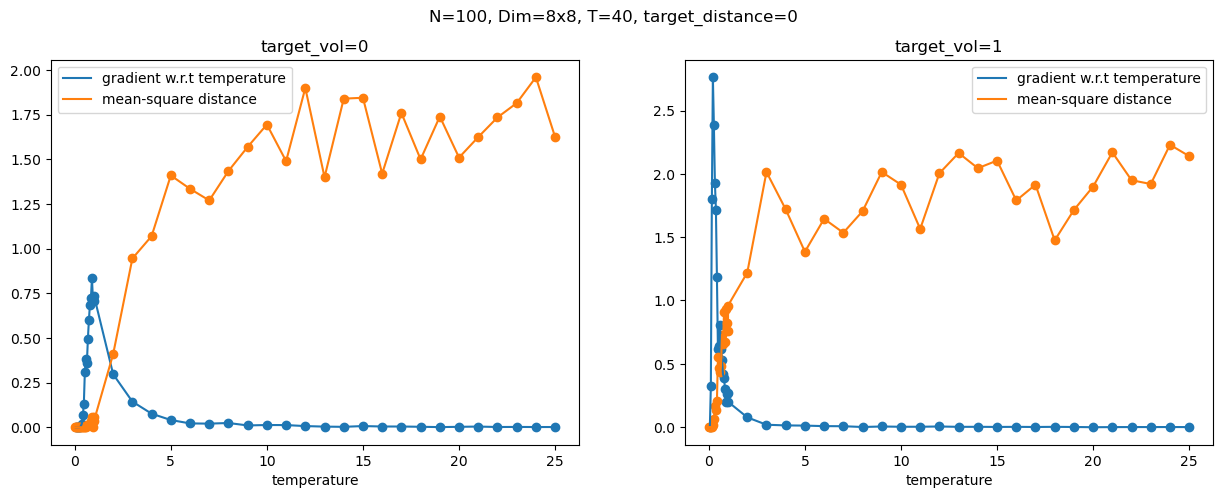

In [45]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(temps.cpu(), grads_v0)
axs[0].plot(temps.cpu(), grads_v0, label="gradient w.r.t temperature")
axs[0].scatter(temps.cpu(), mean_distances_v0)
axs[0].plot(temps.cpu(), mean_distances_v0, label="mean-square distance")
axs[0].set(title="target_vol=0", xlabel="temperature")
axs[0].legend()

axs[1].scatter(temps.cpu(), grads_v1)
axs[1].plot(temps.cpu(), grads_v1, label="gradient w.r.t temperature")
axs[1].scatter(temps.cpu(), mean_distances_v1)
axs[1].plot(temps.cpu(), mean_distances_v1, label="mean-square distance")
axs[1].set(title="target_vol=1", xlabel="temperature")
axs[1].legend()

fig.suptitle("N=100, Dim=8x8, T=40, target_distance=0")
plt.show()


# Introduce Squared loss to target distance

In [13]:
def step(batch:t.Tensor, dist_matrix:t.Tensor, temperature:t.Tensor, target_vol:float, eta:float, num_steps:int, target_distance:float):
    for i in tqdm(range(num_steps)):
        batch = MCS(batch, target_vol, temperature)
        if t.any(t.sum(batch, dim=(-1,-2)) == 0) or t.any(t.sum(batch, dim=(-1,-2)) > 2):
            print("ISSUE DETECTED, STOP SIM")
            return None, None
    # calc the distance after 100 steps    
    distances = t.sum(batch * dist_matrix, dim=(-1,-2)) / t.sum(batch, dim=(-1,-2))
    mean_distance = t.mean(distances)
    print(f"temperature: {temperature}, mean distance: {mean_distance}")
    loss = (mean_distance - target_distance)**2
    grad = t.autograd.grad(loss, temperature)[0]
    print(f"gradient: {grad}")
    return t.clamp(temperature - (eta * grad), min=1e-5, max=40.), grad, mean_distance, loss

## Num_steps = 40, 8x8 grid

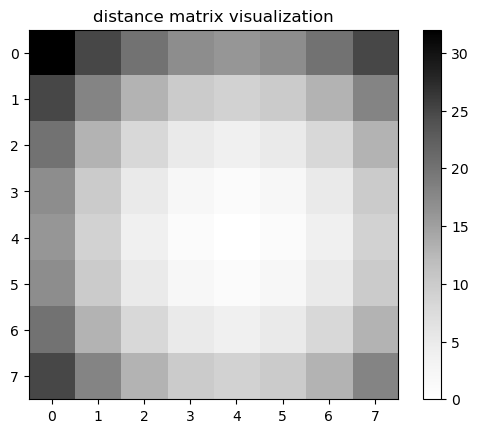

In [14]:
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
fig = plt.imshow(dist_matrix.numpy(), cmap="Greys", interpolation="nearest", vmin=0, vmax=np.max(dist_matrix.numpy()))
plt.colorbar(fig)
plt.title("distance matrix visualization")
plt.show()

target_vol = 0, target_dist = 0

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 0.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.

grads_v0 = []
mean_distances_v0 = []
losses_v0 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v0.append(grad.detach().cpu().numpy())
    mean_distances_v0.append(mean_distance.detach().cpu().numpy())
    losses_v0.append(loss.detach().cpu().numpy())

target_vol = 1, target_dist = 0

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 1.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.

grads_v1 = []
mean_distances_v1 = []
losses_v1 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v1.append(grad.detach().cpu().numpy())
    mean_distances_v1.append(mean_distance.detach().cpu().numpy())
    losses_v1.append(loss.detach().cpu().numpy())

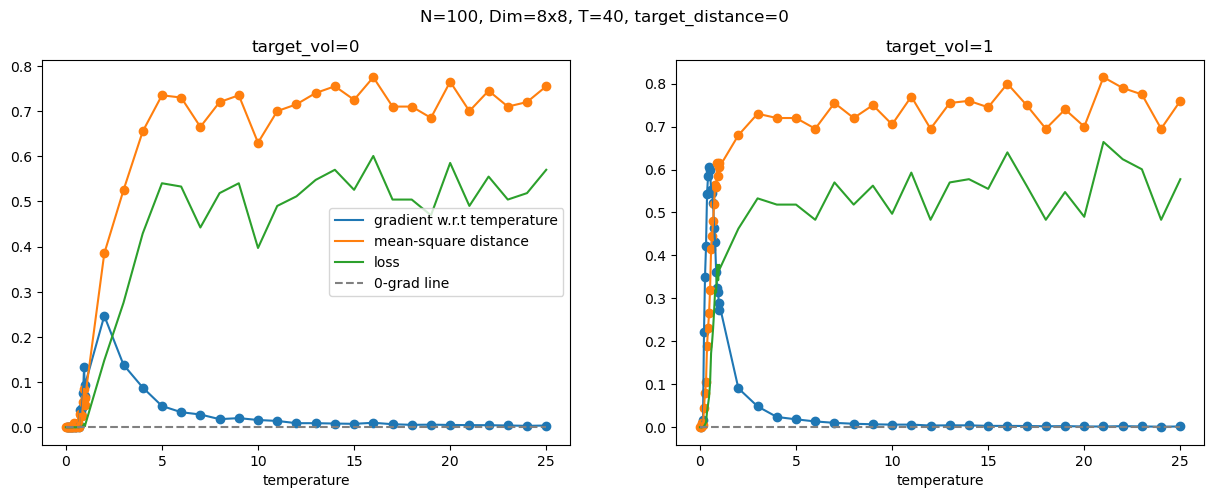

In [24]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(temps.cpu(), grads_v0)
axs[0].plot(temps.cpu(), grads_v0, label="gradient w.r.t temperature")
axs[0].scatter(temps.cpu(), mean_distances_v0)
axs[0].plot(temps.cpu(), mean_distances_v0, label="mean-square distance")
axs[0].plot(temps.cpu(), losses_v0, label="loss")
axs[0].set(title="target_vol=0", xlabel="temperature")
axs[0].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[0].legend()

axs[1].scatter(temps.cpu(), grads_v1)
axs[1].plot(temps.cpu(), grads_v1, label="gradient w.r.t temperature")
axs[1].scatter(temps.cpu(), mean_distances_v1)
axs[1].plot(temps.cpu(), mean_distances_v1, label="mean-square distance")
axs[1].plot(temps.cpu(), losses_v1, label="loss")
axs[1].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[1].set(title="target_vol=1", xlabel="temperature")

fig.suptitle("N=100, Dim=8x8, T=40, target_distance=0")
plt.show()


target_vol = 0, target_dist = 0.2

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 0.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.2

grads_v0 = []
mean_distances_v0 = []
losses_v0 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v0.append(grad.detach().cpu().numpy())
    mean_distances_v0.append(mean_distance.detach().cpu().numpy())
    losses_v0.append(loss.detach().cpu().numpy())

target_vol = 1, target_dist = 0.2

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 1.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.2

grads_v1 = []
mean_distances_v1 = []
losses_v1 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v1.append(grad.detach().cpu().numpy())
    mean_distances_v1.append(mean_distance.detach().cpu().numpy())
    losses_v1.append(loss.detach().cpu().numpy())

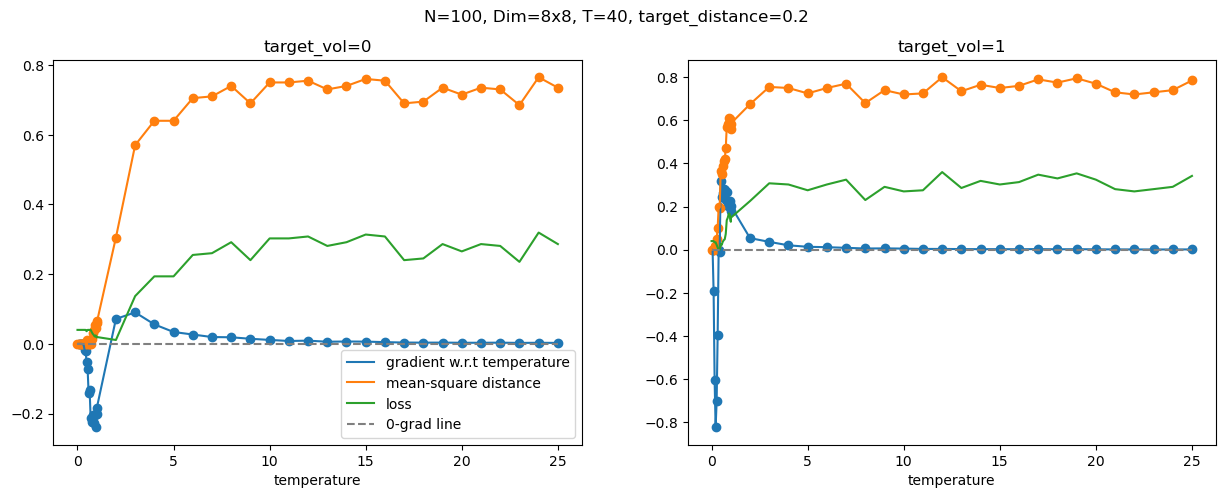

In [28]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(temps.cpu(), grads_v0)
axs[0].plot(temps.cpu(), grads_v0, label="gradient w.r.t temperature")
axs[0].scatter(temps.cpu(), mean_distances_v0)
axs[0].plot(temps.cpu(), mean_distances_v0, label="mean-square distance")
axs[0].plot(temps.cpu(), losses_v0, label="loss")
axs[0].set(title="target_vol=0", xlabel="temperature")
axs[0].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[0].legend()

axs[1].scatter(temps.cpu(), grads_v1)
axs[1].plot(temps.cpu(), grads_v1, label="gradient w.r.t temperature")
axs[1].scatter(temps.cpu(), mean_distances_v1)
axs[1].plot(temps.cpu(), mean_distances_v1, label="mean-square distance")
axs[1].plot(temps.cpu(), losses_v1, label="loss")
axs[1].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[1].set(title="target_vol=1", xlabel="temperature")

fig.suptitle("N=100, Dim=8x8, T=40, target_distance=0.2")
plt.show()


target_vol = 0, target_dist = 0.4

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 0.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.4

grads_v0 = []
mean_distances_v0 = []
losses_v0 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v0.append(grad.detach().cpu().numpy())
    mean_distances_v0.append(mean_distance.detach().cpu().numpy())
    losses_v0.append(loss.detach().cpu().numpy())

target_vol = 1, target_distance = 0.4

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 1.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.4

grads_v1 = []
mean_distances_v1 = []
losses_v1 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v1.append(grad.detach().cpu().numpy())
    mean_distances_v1.append(mean_distance.detach().cpu().numpy())
    losses_v1.append(loss.detach().cpu().numpy())

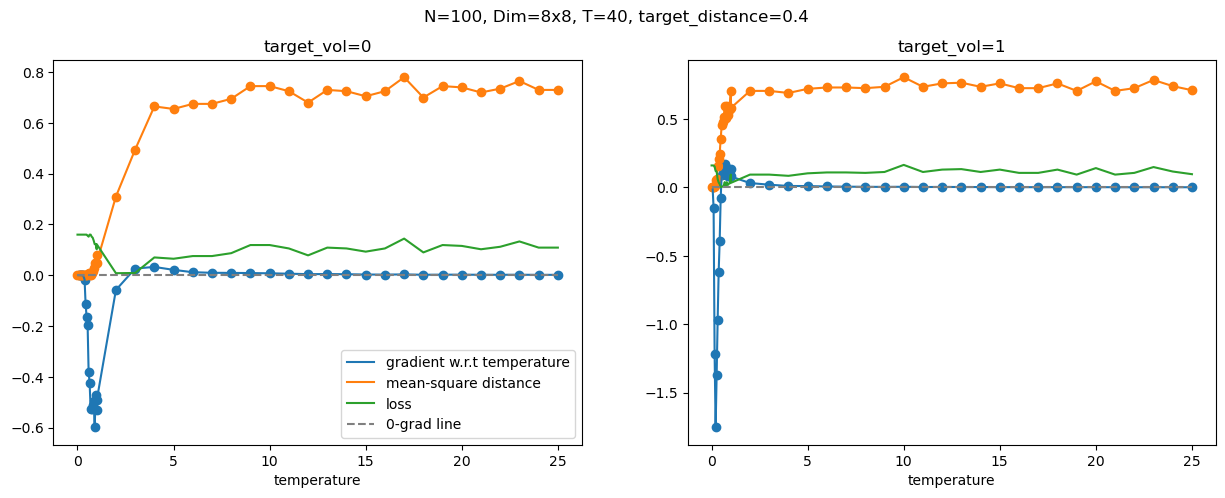

In [31]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(temps.cpu(), grads_v0)
axs[0].plot(temps.cpu(), grads_v0, label="gradient w.r.t temperature")
axs[0].scatter(temps.cpu(), mean_distances_v0)
axs[0].plot(temps.cpu(), mean_distances_v0, label="mean-square distance")
axs[0].plot(temps.cpu(), losses_v0, label="loss")
axs[0].set(title="target_vol=0", xlabel="temperature")
axs[0].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[0].legend()

axs[1].scatter(temps.cpu(), grads_v1)
axs[1].plot(temps.cpu(), grads_v1, label="gradient w.r.t temperature")
axs[1].scatter(temps.cpu(), mean_distances_v1)
axs[1].plot(temps.cpu(), mean_distances_v1, label="mean-square distance")
axs[1].plot(temps.cpu(), losses_v1, label="loss")
axs[1].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[1].set(title="target_vol=1", xlabel="temperature")

fig.suptitle("N=100, Dim=8x8, T=40, target_distance=0.4")
plt.show()


target_vol = 0, target_dist = 0.6

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 0.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.6

grads_v0 = []
mean_distances_v0 = []
losses_v0 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v0.append(grad.detach().cpu().numpy())
    mean_distances_v0.append(mean_distance.detach().cpu().numpy())
    losses_v0.append(loss.detach().cpu().numpy())

target_vol = 1, target_dist = 0.6

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 1.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.6

grads_v1 = []
mean_distances_v1 = []
losses_v1 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v1.append(grad.detach().cpu().numpy())
    mean_distances_v1.append(mean_distance.detach().cpu().numpy())
    losses_v1.append(loss.detach().cpu().numpy())

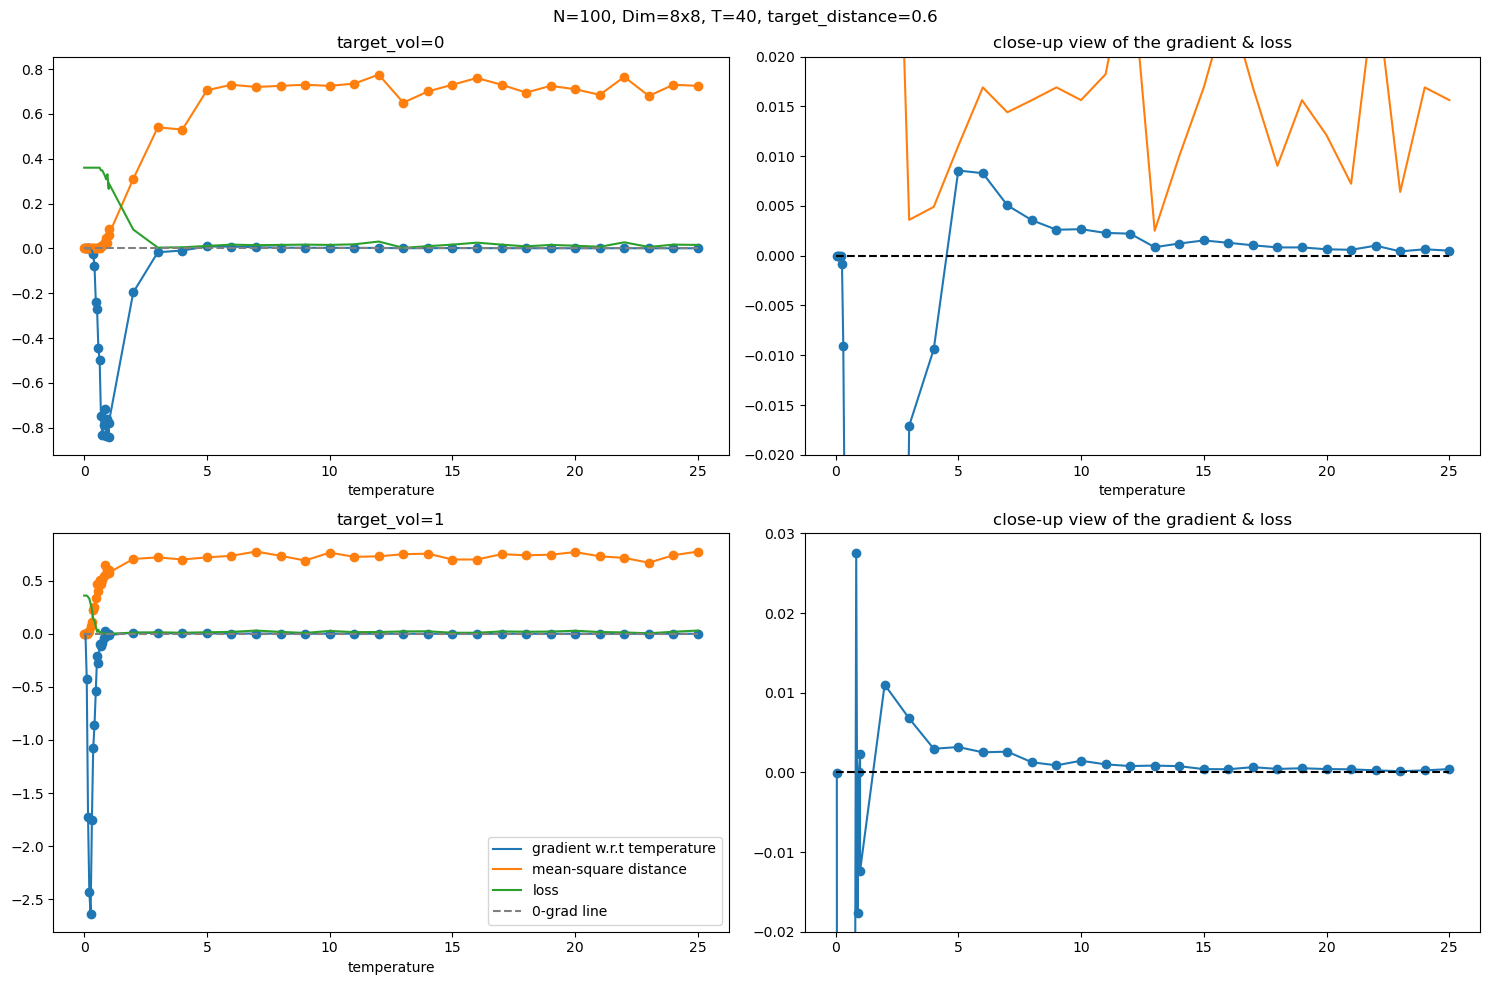

In [58]:
fig, axs = plt.subplots(2,2, figsize=(15,10))
axs[0,0].scatter(temps.cpu(), grads_v0)
axs[0,0].plot(temps.cpu(), grads_v0, label="gradient w.r.t temperature")
axs[0,0].scatter(temps.cpu(), mean_distances_v0)
axs[0,0].plot(temps.cpu(), mean_distances_v0, label="mean-square distance")
axs[0,0].plot(temps.cpu(), losses_v0, label="loss")
axs[0,0].set(title="target_vol=0", xlabel="temperature")
axs[0,0].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")

axs[0,1].scatter(temps.cpu(), grads_v0)
axs[0,1].plot(temps.cpu(), grads_v0, label="gradient w.r.t temperature")
axs[0,1].plot(temps.cpu(), losses_v0)
axs[0,1].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["black"], linestyles="dashed")
axs[0,1].set(title="close-up view of the gradient & loss", ylim=(-0.02,0.02), xlabel="temperature")

axs[1,0].scatter(temps.cpu(), grads_v1)
axs[1,0].plot(temps.cpu(), grads_v1, label="gradient w.r.t temperature")
axs[1,0].scatter(temps.cpu(), mean_distances_v1)
axs[1,0].plot(temps.cpu(), mean_distances_v1, label="mean-square distance")
axs[1,0].plot(temps.cpu(), losses_v1, label="loss")
axs[1,0].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[1,0].set(title="target_vol=1", xlabel="temperature")
axs[1,0].legend()

axs[1,1].scatter(temps.cpu(), grads_v1)
axs[1,1].plot(temps.cpu(), grads_v1, label="gradient w.r.t temperature")
axs[1,1].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["black"], linestyles="dashed")
axs[1,1].set(title="close-up view of the gradient & loss", ylim=(-0.02,0.03))

fig.suptitle("N=100, Dim=8x8, T=40, target_distance=0.6")
fig.tight_layout()
plt.show()


## Num_steps = 500, 256x256 grid

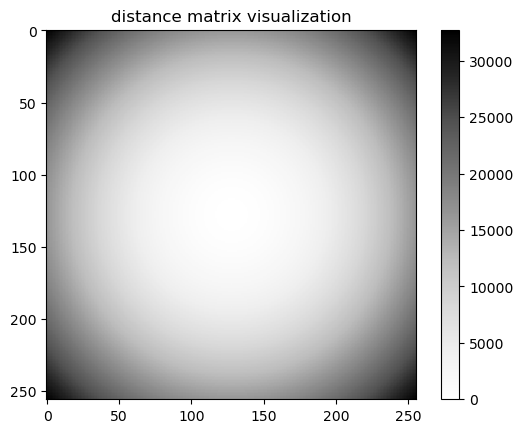

In [60]:
ref = t.zeros(1,256,256, device=device)
ref[:,128,128] += 1
dist_matrix = create_dist_matrix(ref)
fig = plt.imshow(dist_matrix.numpy(), cmap="Greys", interpolation="nearest", vmin=0, vmax=np.max(dist_matrix.numpy()))
plt.colorbar(fig)
plt.title("distance matrix visualization")
plt.show()

target_vol = 0, target_dist = 0

In [62]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 0.
ref = t.zeros(1,256,256, device=device)
ref[:,128,128] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.

grads_v0 = []
mean_distances_v0 = []
losses_v0 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,256,256, device=device)
    batch[:,128,128] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=500, target_distance=target_distance)
    grads_v0.append(grad.detach().cpu().numpy())
    mean_distances_v0.append(mean_distance.detach().cpu().numpy())
    losses_v0.append(loss.detach().cpu().numpy())

100%|██████████| 500/500 [00:19<00:00, 25.77it/s]


temperature: 0.0, mean distance: 0.0
gradient: nan


100%|██████████| 500/500 [00:21<00:00, 22.89it/s]


temperature: 0.05263157933950424, mean distance: 0.0
gradient: 0.0


100%|██████████| 500/500 [00:28<00:00, 17.32it/s]


temperature: 0.10526315867900848, mean distance: 0.0
gradient: 0.0


100%|██████████| 500/500 [00:38<00:00, 13.01it/s]


temperature: 0.15789473056793213, mean distance: 0.0
gradient: 0.0


100%|██████████| 500/500 [00:28<00:00, 17.68it/s]


temperature: 0.21052631735801697, mean distance: 0.0
gradient: 0.0


100%|██████████| 500/500 [00:28<00:00, 17.78it/s]


temperature: 0.2631579041481018, mean distance: 0.0
gradient: 0.0


100%|██████████| 500/500 [00:35<00:00, 14.14it/s]


temperature: 0.31578946113586426, mean distance: 0.0
gradient: 0.0


100%|██████████| 500/500 [00:29<00:00, 16.95it/s]


temperature: 0.3684210479259491, mean distance: 0.010000000000000002
gradient: 0.006205829791724682


100%|██████████| 500/500 [00:31<00:00, 16.12it/s]


temperature: 0.42105263471603394, mean distance: 0.0
gradient: 0.0


100%|██████████| 500/500 [00:25<00:00, 19.63it/s]


temperature: 0.4736842215061188, mean distance: 0.010000000000000002
gradient: 0.0277959406375885


100%|██████████| 500/500 [00:36<00:00, 13.85it/s]


temperature: 0.5263158082962036, mean distance: 0.025000000000000005
gradient: 0.10774417221546173


100%|██████████| 500/500 [00:28<00:00, 17.58it/s]


temperature: 0.5789473652839661, mean distance: 0.03500000000000001
gradient: 0.1699220836162567


100%|██████████| 500/500 [00:36<00:00, 13.78it/s]


temperature: 0.6315789222717285, mean distance: 0.075
gradient: 0.34431442618370056


100%|██████████| 500/500 [00:28<00:00, 17.27it/s]


temperature: 0.6842105388641357, mean distance: 0.14500000000000002
gradient: 0.5979253649711609


100%|██████████| 500/500 [00:30<00:00, 16.35it/s]


temperature: 0.7368420958518982, mean distance: 0.185
gradient: 0.7109333276748657


100%|██████████| 500/500 [00:30<00:00, 16.30it/s]


temperature: 0.7894736528396606, mean distance: 0.21
gradient: 0.6806349754333496


100%|██████████| 500/500 [00:27<00:00, 18.03it/s]


temperature: 0.8421052694320679, mean distance: 0.245
gradient: 0.7251306176185608


100%|██████████| 500/500 [00:35<00:00, 14.21it/s]


temperature: 0.8947368264198303, mean distance: 0.375
gradient: 0.8540289998054504


100%|██████████| 500/500 [00:35<00:00, 13.92it/s]


temperature: 0.9473684430122375, mean distance: 0.37
gradient: 0.8315809369087219


100%|██████████| 500/500 [00:29<00:00, 17.11it/s]


temperature: 1.0, mean distance: 0.47
gradient: 0.8734839558601379


100%|██████████| 500/500 [00:23<00:00, 21.08it/s]


temperature: 1.0, mean distance: 0.46
gradient: 0.8638509511947632


100%|██████████| 500/500 [00:36<00:00, 13.55it/s]


temperature: 2.0, mean distance: 0.765
gradient: 0.2251504361629486


100%|██████████| 500/500 [00:31<00:00, 15.87it/s]


temperature: 3.0, mean distance: 0.725
gradient: 0.11395251750946045


100%|██████████| 500/500 [00:41<00:00, 12.11it/s]


temperature: 4.0, mean distance: 0.765
gradient: 0.06656765192747116


100%|██████████| 500/500 [00:35<00:00, 14.09it/s]


temperature: 5.0, mean distance: 0.78
gradient: 0.039428163319826126


100%|██████████| 500/500 [00:38<00:00, 12.98it/s]


temperature: 6.0, mean distance: 0.76
gradient: 0.032565779983997345


100%|██████████| 500/500 [00:38<00:00, 12.90it/s]


temperature: 7.0, mean distance: 0.735
gradient: 0.025669988244771957


100%|██████████| 500/500 [00:28<00:00, 17.45it/s]


temperature: 8.0, mean distance: 0.795
gradient: 0.018984079360961914


100%|██████████| 500/500 [00:32<00:00, 15.33it/s]


temperature: 9.0, mean distance: 0.72
gradient: 0.015162668190896511


100%|██████████| 500/500 [00:30<00:00, 16.61it/s]


temperature: 10.0, mean distance: 0.755
gradient: 0.015737388283014297


100%|██████████| 500/500 [00:19<00:00, 25.96it/s]


temperature: 11.0, mean distance: 0.725
gradient: 0.010736173950135708


100%|██████████| 500/500 [00:18<00:00, 26.39it/s]


temperature: 12.0, mean distance: 0.73
gradient: 0.010442357510328293


100%|██████████| 500/500 [00:18<00:00, 26.57it/s]


temperature: 13.0, mean distance: 0.78
gradient: 0.008754841983318329


100%|██████████| 500/500 [00:19<00:00, 26.25it/s]


temperature: 14.0, mean distance: 0.7
gradient: 0.007315525319427252


100%|██████████| 500/500 [00:18<00:00, 26.88it/s]


temperature: 15.0, mean distance: 0.81
gradient: 0.008179323747754097


100%|██████████| 500/500 [00:18<00:00, 26.66it/s]


temperature: 16.0, mean distance: 0.725
gradient: 0.006339521612972021


100%|██████████| 500/500 [00:18<00:00, 26.72it/s]


temperature: 17.0, mean distance: 0.74
gradient: 0.005205527413636446


100%|██████████| 500/500 [00:18<00:00, 26.64it/s]


temperature: 18.0, mean distance: 0.765
gradient: 0.005441139917820692


100%|██████████| 500/500 [00:18<00:00, 26.39it/s]


temperature: 19.0, mean distance: 0.77
gradient: 0.00529021630063653


100%|██████████| 500/500 [00:18<00:00, 26.82it/s]


temperature: 20.0, mean distance: 0.735
gradient: 0.004008286166936159


100%|██████████| 500/500 [00:18<00:00, 27.00it/s]


temperature: 21.0, mean distance: 0.8
gradient: 0.004600102547556162


100%|██████████| 500/500 [00:18<00:00, 26.90it/s]


temperature: 22.0, mean distance: 0.765
gradient: 0.0042938911356031895


100%|██████████| 500/500 [00:18<00:00, 26.69it/s]


temperature: 23.0, mean distance: 0.75
gradient: 0.0034172667656093836


100%|██████████| 500/500 [00:18<00:00, 26.73it/s]


temperature: 24.0, mean distance: 0.755
gradient: 0.00395599752664566


100%|██████████| 500/500 [00:18<00:00, 26.52it/s]


temperature: 25.0, mean distance: 0.765
gradient: 0.003250155597925186


target_vol = 1, target_dist = 0

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 1.
ref = t.zeros(1,256,256, device=device)
ref[:,128,128] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.

grads_v1 = []
mean_distances_v1 = []
losses_v1 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,256,256, device=device)
    batch[:,128,128] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=500, target_distance=target_distance)
    grads_v1.append(grad.detach().cpu().numpy())
    mean_distances_v1.append(mean_distance.detach().cpu().numpy())
    losses_v1.append(loss.detach().cpu().numpy())